In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Data

In [ ]:
url = 'https://query1.finance.yahoo.com/v7/finance/download/ICBP.JK?period1=1491177600&period2=1648944000&interval=1d&events=history&includeAdjustedClose=true'
icbp = pd.read_csv(url)
icbp['Date'] = pd.to_datetime(icbp['Date'])
icbp = icbp[~icbp.Date.duplicated()]
# icbp = icbp.set_index(['Date']).asfreq('D').fillna(method='ffill')
icbp

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-03,8200.0,8450.0,8200.0,8425.0,7429.060059,2068600.0
1,2017-04-04,8400.0,8425.0,8275.0,8400.0,7407.015137,3444200.0
2,2017-04-05,8400.0,8400.0,8400.0,8400.0,7407.015137,0.0
3,2017-04-06,8300.0,8325.0,8200.0,8225.0,7252.702637,10471800.0
4,2017-04-07,8200.0,8225.0,8150.0,8175.0,7208.613281,7078600.0
...,...,...,...,...,...,...,...
1255,2022-03-28,7250.0,7400.0,7200.0,7275.0,7275.000000,13828500.0
1256,2022-03-29,7300.0,7400.0,7250.0,7300.0,7300.000000,9243600.0
1257,2022-03-30,7350.0,7475.0,7325.0,7375.0,7375.000000,9768800.0
1258,2022-03-31,7400.0,7450.0,7300.0,7350.0,7350.000000,6875300.0


In [ ]:
icbp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 78.8 KB


In [ ]:
icbp.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,9361.119936,9453.733122,9250.734710,9352.521843,8847.075132,6.206952e+06
std,1048.674051,1057.053850,1033.571492,1046.643271,1077.616521,7.947993e+06
min,7250.000000,7400.000000,7200.000000,7250.000000,7142.479492,0.000000e+00
25%,8675.000000,8750.000000,8550.000000,8650.000000,7962.741455,2.861350e+06
50%,8900.000000,8975.000000,8800.000000,8900.000000,8550.000000,4.626600e+06
75%,10075.000000,10175.000000,9950.000000,10075.000000,9620.093750,7.381550e+06
max,12500.000000,12550.000000,12275.000000,12400.000000,11810.808594,2.044506e+08


In [ ]:
icbp['Date'].min()

Timestamp('2017-04-03 00:00:00')

In [ ]:
# create valid date range
start = icbp['Date'].min()
end = icbp['Date'].max()

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = icbp[(icbp['Date'] >= start) & (icbp['Date'] <= end)].groupby([pd.Grouper(key='Date', freq='W-MON')]).first().reset_index()
weekly_rows.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-03,8200.0,8450.0,8200.0,8425.0,7429.060547,2068600.0
1,2017-04-10,8400.0,8425.0,8275.0,8400.0,7407.015625,3444200.0
2,2017-04-17,8200.0,8225.0,8100.0,8125.0,7164.523438,7277700.0
3,2017-04-24,8175.0,8200.0,8075.0,8200.0,7230.657715,7389500.0
4,2017-05-01,8450.0,8500.0,8375.0,8500.0,7495.194824,6203900.0


In [ ]:
weekly_rows.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
257,2022-03-07,8500.0,8525.0,8150.0,8250.0,8250.0,21470900.0
258,2022-03-14,7400.0,7600.0,7400.0,7600.0,7600.0,21825800.0
259,2022-03-21,7525.0,7600.0,7375.0,7425.0,7425.0,15064300.0
260,2022-03-28,7475.0,7600.0,7475.0,7475.0,7475.0,4588300.0
261,2022-04-04,7300.0,7400.0,7250.0,7300.0,7300.0,9243600.0


In [ ]:
!pip install plotly==5.6.0

     |████████████████████████████████| 27.7 MB 1.6 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [ ]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=825630794617ba3f623db6f570944e3b426511eace637019d4ea88cee05b1999
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
from plotly import tools
import chart_studio.plotly as py
import plotly.graph_objs as go
import gc
from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)

ModuleNotFoundError: ignored

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
# trace3 = go.Scatter(
#     x = weekly_rows['Date'],
#     y = weekly_rows['Adj Close'].astype(float),
#     mode = 'lines',
#     name = 'Adj Close'
# )

layout = dict(
    title='Historical ICBP Prices (2017-2022) with the Slider ',
    hovermode='x',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

# data = [trace1,trace2, trace3]
data = [trace1,trace2]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")
# fig.show()

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = weekly_rows['Volume'].astype(float),
    mode = 'lines',
    name = 'Volume'
)

layout = dict(
    title='Historical ICBP Volume (IDR) (2017-2022) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [ ]:
trace = go.Scattergl(
    y = weekly_rows['Volume'].astype(float),
    x = weekly_rows['Close'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='ICBP Volume v/s IDR',
    xaxis=dict(
        title='Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='compare_webgl')

# Eksplorasi Data

In [ ]:
icbp2 = icbp.set_index(['Date']).asfreq('D').fillna(method='ffill')

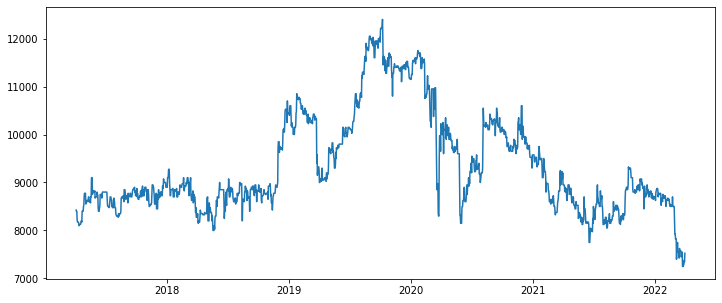

In [ ]:
ts = icbp2['Close']
plt.figure(figsize=(12,5))
plt.plot(ts)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



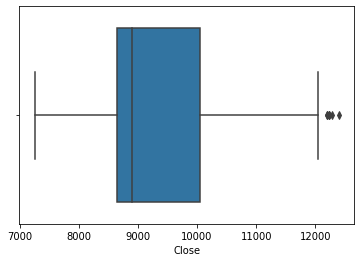

In [ ]:
sns.boxplot(ts)

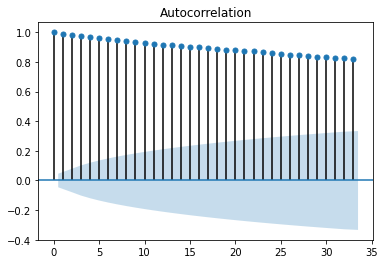

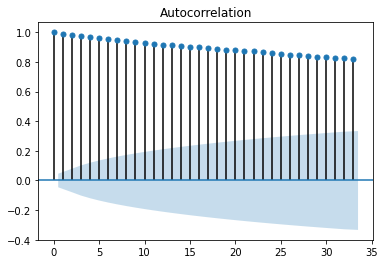

In [ ]:
plot_acf(ts)

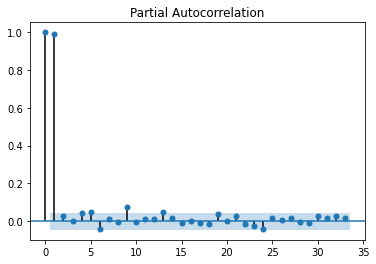

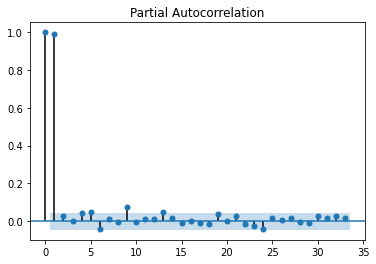

In [ ]:
plot_pacf(ts)

# Split Data

In [ ]:
def train_test_split_sequence(ts, prop_train=.8):
  split_point = round(prop_train * len(ts))
  train, test = ts[:split_point+1], ts[split_point+1:]
  return train, test

def input_output_split_sequence(seq, n_steps):
  X, y = [], []
  for i in range(len(seq)):
    end_ix = i + n_steps
    if end_ix > len(seq) - 1:
      break
    seq_x, seq_y = seq[i:end_ix], seq[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

def split_sequence(seq, n_steps=1):
  X, y = [], []
  for i in range(len(seq)-n_steps-1):
    v = seq[i:(i+n_steps), 0]
    X.append(v)
    y.append(seq[i + n_steps, 0])
  return np.array(X), np.array(y)

## Split LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
ts = icbp2[['Close']]

ts.values

array([[8425.],
       [8400.],
       [8400.],
       ...,
       [7375.],
       [7350.],
       [7525.]])

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
ts = scaler.fit_transform(ts)

ts

array([[0.22815534],
       [0.22330097],
       [0.22330097],
       ...,
       [0.02427184],
       [0.01941748],
       [0.05339806]])

In [ ]:
ts.shape

(1825, 1)

In [ ]:
train, test = train_test_split_sequence(ts)

output = f'''
Train: 
{train.shape}

Text:
{test.shape}
'''
print(output)


Train: 
(1461, 1)

Text:
(364, 1)



In [ ]:
X_train, y_train = split_sequence(train, n_steps=7)
X_test, y_test = split_sequence(test, n_steps=7)

output = f'''
X train ({X_train.shape}): 
{X_train}

y train ({y_train.shape}):
{y_train}
'''
print(output)


X train ((1453, 7)): 
[[0.22815534 0.22330097 0.22330097 ... 0.17961165 0.17961165 0.17961165]
 [0.22330097 0.22330097 0.18932039 ... 0.17961165 0.17961165 0.17961165]
 [0.22330097 0.18932039 0.17961165 ... 0.17961165 0.17961165 0.16990291]
 ...
 [0.37864078 0.38834951 0.33009709 ... 0.3592233  0.3592233  0.38349515]
 [0.38834951 0.33009709 0.3592233  ... 0.3592233  0.38349515 0.35436893]
 [0.33009709 0.3592233  0.3592233  ... 0.38349515 0.35436893 0.37864078]]

y train ((1453,)):
[0.17961165 0.16990291 0.16504854 ... 0.35436893 0.37864078 0.33009709]



In [ ]:
y_train.shape

(1453,)

In [ ]:
X_train.shape

(1453, 7)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

(1453, 1, 7)

## Split CNN

In [ ]:
ts2 = icbp2['Close']

In [ ]:
ts2

Date
2017-04-03    8425.0
2017-04-04    8400.0
2017-04-05    8400.0
2017-04-06    8225.0
2017-04-07    8175.0
               ...  
2022-03-28    7275.0
2022-03-29    7300.0
2022-03-30    7375.0
2022-03-31    7350.0
2022-04-01    7525.0
Freq: D, Name: Close, Length: 1825, dtype: float64

In [ ]:
train2, test2 = train_test_split_sequence(ts2)

output = f'''
Train: 
{train2}

Text:
{test2}
'''
print(output)


Train: 
Date
2017-04-03    8425.0
2017-04-04    8400.0
2017-04-05    8400.0
2017-04-06    8225.0
2017-04-07    8175.0
               ...  
2021-03-29    9225.0
2021-03-30    9075.0
2021-03-31    9200.0
2021-04-01    8950.0
2021-04-02    8950.0
Freq: D, Name: Close, Length: 1461, dtype: float64

Text:
Date
2021-04-03    8950.0
2021-04-04    8950.0
2021-04-05    8925.0
2021-04-06    8825.0
2021-04-07    8900.0
               ...  
2022-03-28    7275.0
2022-03-29    7300.0
2022-03-30    7375.0
2022-03-31    7350.0
2022-04-01    7525.0
Freq: D, Name: Close, Length: 364, dtype: float64



In [ ]:
train2.shape

(1461,)

In [ ]:
X_train2, y_train2 = input_output_split_sequence(train2, n_steps=7)
X_test2, y_test2 = input_output_split_sequence(test2, n_steps=7)

output = f'''
X train ({X_train2.shape}): 
{X_train2}

y train ({y_train2.shape}):
{y_train2}
'''
print(output)


X train ((1454, 7)): 
[[8425. 8400. 8400. ... 8175. 8175. 8175.]
 [8400. 8400. 8225. ... 8175. 8175. 8175.]
 [8400. 8225. 8175. ... 8175. 8175. 8125.]
 ...
 [9250. 8950. 9100. ... 9100. 9225. 9075.]
 [8950. 9100. 9100. ... 9225. 9075. 9200.]
 [9100. 9100. 9100. ... 9075. 9200. 8950.]]

y train ((1454,)):
[8175. 8125. 8100. ... 9200. 8950. 8950.]



# Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
# from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:
import keras_tuner as kt

## Vanilla LSTM

### Model

In [ ]:
def model_builder(hp):
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units_lstm = hp.Int('units_lstm', min_value=32, max_value=512, step=32)
  model.add(LSTM(hp_units_lstm, activation='relu', input_shape=(1, 7)))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mae')

  return model

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner = kt.RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=10,
                     seed=42,
                     executions_per_trial=2,
                     directory='icbp',
                     project_name='vanilla-lstm'
                    # # FOR TRAIN ONLY
                    #  overwrite=True
                    # # --------------
                     )

tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_lstm', 'learning_rate']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Trial 10 Complete [00h 01m 09s]
val_loss: 0.015958890318870544

Best val_loss So Far: 0.015361621510237455
Total elapsed time: 00h 10m 33s
INFO:tensorflow:Oracle triggered exit
Best tune:
units_lstm: 320
learning_rate: 0.01


In [ ]:
tuner.results_summary(num_trials=10)

Results summary
Results in icbp/vanilla-lstm
Showing 10 best trials
Trial summary
Hyperparameters:
units_lstm: 320
learning_rate: 0.01
Score: 0.015361621510237455
Trial summary
Hyperparameters:
units_lstm: 352
learning_rate: 0.01
Score: 0.01546606095507741
Trial summary
Hyperparameters:
units_lstm: 256
learning_rate: 0.01
Score: 0.015473829582333565
Trial summary
Hyperparameters:
units_lstm: 288
learning_rate: 0.01
Score: 0.015505371615290642
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.01
Score: 0.015611226204782724
Trial summary
Hyperparameters:
units_lstm: 448
learning_rate: 0.001
Score: 0.01594062428921461
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.001
Score: 0.015958890318870544
Trial summary
Hyperparameters:
units_lstm: 192
learning_rate: 0.001
Score: 0.016088862903416157
Trial summary
Hyperparameters:
units_lstm: 224
learning_rate: 0.001
Score: 0.016196105629205704
Trial summary
Hyperparameters:
units_lstm: 512
learning_rate: 0.0001
Score:

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
lstm = tuner.hypermodel.build(best_hp)

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 320)               419840    
                                                                 
 dense_1 (Dense)             (None, 1)                 321       
                                                                 
Total params: 420,161
Trainable params: 420,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm = Sequential()
lstm.add(LSTM(4, input_shape=(1, 7)))
lstm.add(Dense(1))

lstm.compile(loss='mae', optimizer='adam')

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 192       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstm = lstm.fit(X_train, y_train, 
                       batch_size=1, 
                       epochs=50,
                       validation_data=(X_test, y_test), 
                       verbose=2)

Epoch 1/50
1453/1453 - 13s - loss: 0.0475 - val_loss: 0.0329 - 13s/epoch - 9ms/step
Epoch 2/50
1453/1453 - 9s - loss: 0.0398 - val_loss: 0.0658 - 9s/epoch - 6ms/step
Epoch 3/50
1453/1453 - 6s - loss: 0.0368 - val_loss: 0.0398 - 6s/epoch - 4ms/step
Epoch 4/50
1453/1453 - 5s - loss: 0.0339 - val_loss: 0.0516 - 5s/epoch - 4ms/step
Epoch 5/50
1453/1453 - 5s - loss: 0.0306 - val_loss: 0.0395 - 5s/epoch - 4ms/step
Epoch 6/50
1453/1453 - 5s - loss: 0.0290 - val_loss: 0.0628 - 5s/epoch - 4ms/step
Epoch 7/50
1453/1453 - 5s - loss: 0.0270 - val_loss: 0.0333 - 5s/epoch - 4ms/step
Epoch 8/50
1453/1453 - 5s - loss: 0.0265 - val_loss: 0.0250 - 5s/epoch - 4ms/step
Epoch 9/50
1453/1453 - 5s - loss: 0.0262 - val_loss: 0.0267 - 5s/epoch - 4ms/step
Epoch 10/50
1453/1453 - 6s - loss: 0.0254 - val_loss: 0.0294 - 6s/epoch - 4ms/step
Epoch 11/50
1453/1453 - 5s - loss: 0.0260 - val_loss: 0.0276 - 5s/epoch - 4ms/step
Epoch 12/50
1453/1453 - 5s - loss: 0.0246 - val_loss: 0.0274 - 5s/epoch - 4ms/step
Epoch 13/50

In [ ]:
lstm.save('vanilla_lstm.h5')

### Evaluation

In [ ]:
train_predict = lstm.predict(X_train)
test_predict = lstm.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([y_test])

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics 

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict)

,MSE,RMSE,MAE,MAPE
0,22317.417773,149.390153,100.44915,0.010407


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict)

,MSE,RMSE,MAE,MAPE
0,14976.625376,122.379023,87.167432,0.010493


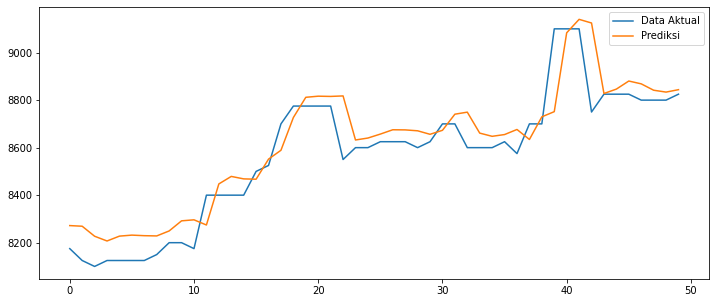

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0][:50])
plt.plot(train_predict[:50])
plt.legend(['Data Aktual', 'Prediksi'])

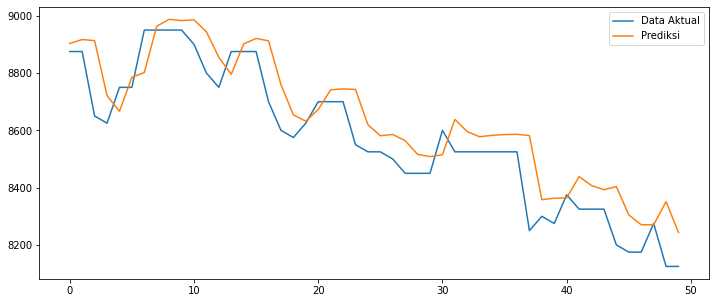

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][:50])
plt.plot(test_predict[:50])
plt.legend(['Data Aktual', 'Prediksi'])

## CNN-LSTM

### Model

In [ ]:
from pandas.core.common import flatten
lstmcnn = Sequential()

lstmcnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
lstmcnn.add(LSTM(64, activation='relu'))
lstmcnn.add(Dense(64, activation='relu'))
lstmcnn.add(Dense(1))

lstmcnn.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.001))

lstmcnn.build(input_shape=(None, 7, 1))
lstmcnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             192       
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,441
Trainable params: 37,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstmncnn = lstmcnn.fit(X_train2, y_train2, epochs=150, validation_data=(X_test2, y_test2))

Epoch 1/150
46/46 [==============================] - 2s 10ms/step - loss: 1791.8490 - val_loss: 134.2160
Epoch 2/150
46/46 [==============================] - 0s 6ms/step - loss: 174.0897 - val_loss: 125.5522
Epoch 3/150
46/46 [==============================] - 0s 5ms/step - loss: 169.5283 - val_loss: 117.3429
Epoch 4/150
46/46 [==============================] - 0s 10ms/step - loss: 162.1541 - val_loss: 120.7221
Epoch 5/150
46/46 [==============================] - 1s 13ms/step - loss: 161.1771 - val_loss: 117.4439
Epoch 6/150
46/46 [==============================] - 0s 6ms/step - loss: 172.0187 - val_loss: 112.4365
Epoch 7/150
46/46 [==============================] - 0s 5ms/step - loss: 153.3022 - val_loss: 152.4841
Epoch 8/150
46/46 [==============================] - 0s 5ms/step - loss: 153.5449 - val_loss: 114.1423
Epoch 9/150
46/46 [==============================] - 0s 5ms/step - loss: 170.6332 - val_loss: 118.5394
Epoch 10/150
46/46 [==============================] - 0s 5ms/step - l

In [ ]:
lstmcnn.save('cnn_lstm.h5')

### Evaluation

In [ ]:
cnn_train = lstmcnn.predict(X_train2)
cnn_test = lstmcnn.predict(X_test2)

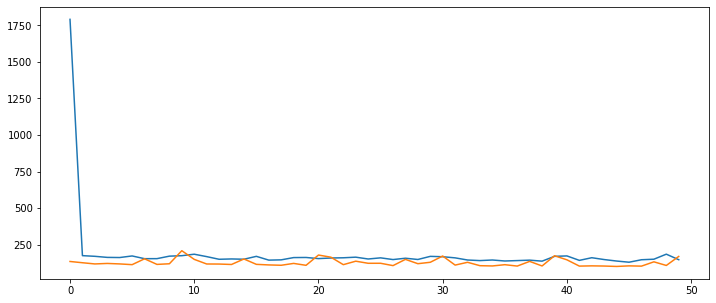

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(historylstmncnn.history['loss'][:50])
plt.plot(historylstmncnn.history['val_loss'][:50])

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics 

In [ ]:
metrics_evaluation_regression(y_train2, lstmcnn.predict(X_train2))

,MSE,RMSE,MAE,MAPE
0,19680.56353,140.287432,84.143688,0.008833


In [ ]:
metrics_evaluation_regression(y_test2, lstmcnn.predict(X_test2))

,MSE,RMSE,MAE,MAPE
0,11903.910186,109.105042,71.649232,0.008518


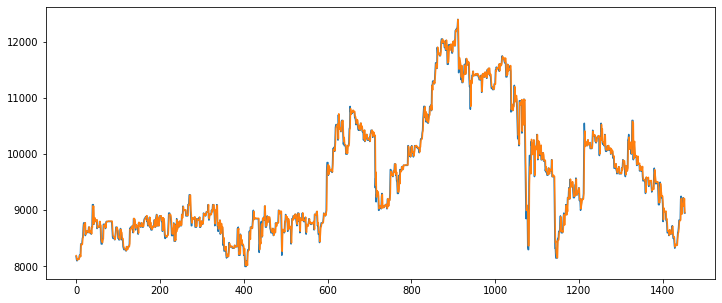

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_train2)
plt.plot(lstmcnn.predict(X_train2))

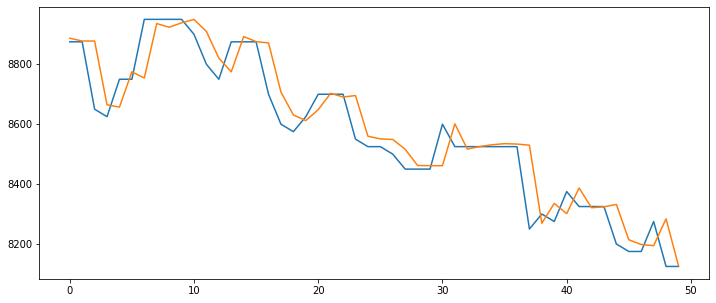

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test2[:50])
plt.plot(lstmcnn.predict(X_test2[:50]))

## BiLSTM

### Model

In [ ]:
def bilstm_builder(hp):
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units_lstm = hp.Int('units_lstm', min_value=32, max_value=512, step=32)
  model.add(Bidirectional(LSTM(hp_units_lstm, activation='relu', input_shape=(1, 7))))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mae')

  return model

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
bilstmtuner = kt.RandomSearch(bilstm_builder,
                     objective='val_loss',
                     max_trials=10,
                     seed=42,
                     executions_per_trial=2,
                     directory='icbp',
                     project_name='bi-lstm'
                    # # FOR TRAIN ONLY
                    #  overwrite=True
                    # # --------------
                     )

bilstmtuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=bilstmtuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_lstm', 'learning_rate']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Trial 9 Complete [00h 00m 45s]
val_loss: 0.015861857682466507

Best val_loss So Far: 0.015291950665414333
Total elapsed time: 00h 14m 13s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
480               |320               |units_lstm
0.001             |0.01              |learning_rate

Epoch 1/50
37/37 [==============================] - 5s 44ms/step - loss: 0.1381 - val_loss: 0.0270
Epoch 2/50
37/37 [==============================] - 1s 32ms/step - loss: 0.0285 - val_loss: 0.0236
Epoch 3/50
37/37 [==============================] - 1s 32ms/step - loss: 0.0273 - val_loss: 0.0228
Epoch 4/50
37/37 [==============================] - 1s 32ms/step - loss: 0.0260 - val_loss: 0.0225
Epoch 5/50
37/37 [==============================] - 1s 31ms/step - loss: 0.0244 - val_loss: 0.0216
Epoch 6/50
37/37 [==============================] - 1s 32ms/step - loss: 0.0239 - val_loss: 0.0216
Epoch 7/50
37/37 [==============================] - 1s 30ms/step - loss: 0.0237 - val

In [ ]:
bilstmtuner.results_summary(num_trials=10)

Results summary
Results in icbp/bi-lstm
Showing 10 best trials
Trial summary
Hyperparameters:
units_lstm: 320
learning_rate: 0.01
Score: 0.015291950665414333
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.01
Score: 0.015427079051733017
Trial summary
Hyperparameters:
units_lstm: 288
learning_rate: 0.01
Score: 0.015436977613717318
Trial summary
Hyperparameters:
units_lstm: 256
learning_rate: 0.01
Score: 0.015460789203643799
Trial summary
Hyperparameters:
units_lstm: 448
learning_rate: 0.001
Score: 0.01550437742844224
Trial summary
Hyperparameters:
units_lstm: 352
learning_rate: 0.01
Score: 0.015566359739750624
Trial summary
Hyperparameters:
units_lstm: 480
learning_rate: 0.001
Score: 0.015573587734252214
Trial summary
Hyperparameters:
units_lstm: 192
learning_rate: 0.001
Score: 0.015861857682466507
Trial summary
Hyperparameters:
units_lstm: 224
learning_rate: 0.001
Score: 0.015939677134156227
Trial summary
Hyperparameters:
units_lstm: 512
learning_rate: 0.0001
Score: 0.0

In [ ]:
best_hp = bilstmtuner.get_best_hyperparameters()[0]
bilstm = bilstmtuner.hypermodel.build(best_hp)

# bilstm.summary()

In [ ]:
historybilstm = bilstm.fit(X_train, y_train, 
                       epochs=50,
                       validation_data=(X_test, y_test), 
                       verbose=2)

Epoch 1/50
46/46 - 4s - loss: 0.0793 - val_loss: 0.0265 - 4s/epoch - 84ms/step
Epoch 2/50
46/46 - 1s - loss: 0.0324 - val_loss: 0.0263 - 699ms/epoch - 15ms/step
Epoch 3/50
46/46 - 1s - loss: 0.0294 - val_loss: 0.0182 - 682ms/epoch - 15ms/step
Epoch 4/50
46/46 - 1s - loss: 0.0234 - val_loss: 0.0170 - 702ms/epoch - 15ms/step
Epoch 5/50
46/46 - 1s - loss: 0.0246 - val_loss: 0.0160 - 690ms/epoch - 15ms/step
Epoch 6/50
46/46 - 1s - loss: 0.0226 - val_loss: 0.0156 - 714ms/epoch - 16ms/step
Epoch 7/50
46/46 - 1s - loss: 0.0202 - val_loss: 0.0175 - 708ms/epoch - 15ms/step
Epoch 8/50
46/46 - 1s - loss: 0.0208 - val_loss: 0.0152 - 755ms/epoch - 16ms/step
Epoch 9/50
46/46 - 1s - loss: 0.0193 - val_loss: 0.0194 - 699ms/epoch - 15ms/step
Epoch 10/50
46/46 - 1s - loss: 0.0206 - val_loss: 0.0148 - 705ms/epoch - 15ms/step
Epoch 11/50
46/46 - 1s - loss: 0.0201 - val_loss: 0.0156 - 766ms/epoch - 17ms/step
Epoch 12/50
46/46 - 1s - loss: 0.0249 - val_loss: 0.0150 - 677ms/epoch - 15ms/step
Epoch 13/50
46/4

In [ ]:
bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(4, input_shape=(1, 7))))
bilstm.add(Dense(1))

bilstm.compile(loss='mae', optimizer='adam')

# bilstm.summary()

In [ ]:
historylstm = bilstm.fit(X_train, y_train, 
                       batch_size=1, 
                       epochs=50, 
                       validation_data=(X_test, y_test), 
                       verbose=2)

Epoch 1/50
1453/1453 - 6s - loss: 0.0357 - val_loss: 0.0208 - 6s/epoch - 4ms/step
Epoch 2/50
1453/1453 - 2s - loss: 0.0250 - val_loss: 0.0221 - 2s/epoch - 1ms/step
Epoch 3/50
1453/1453 - 2s - loss: 0.0237 - val_loss: 0.0188 - 2s/epoch - 1ms/step
Epoch 4/50
1453/1453 - 5s - loss: 0.0223 - val_loss: 0.0191 - 5s/epoch - 4ms/step
Epoch 5/50
1453/1453 - 4s - loss: 0.0205 - val_loss: 0.0168 - 4s/epoch - 3ms/step
Epoch 6/50
1453/1453 - 4s - loss: 0.0198 - val_loss: 0.0200 - 4s/epoch - 3ms/step
Epoch 7/50
1453/1453 - 4s - loss: 0.0192 - val_loss: 0.0157 - 4s/epoch - 3ms/step
Epoch 8/50
1453/1453 - 4s - loss: 0.0187 - val_loss: 0.0150 - 4s/epoch - 3ms/step
Epoch 9/50
1453/1453 - 4s - loss: 0.0190 - val_loss: 0.0171 - 4s/epoch - 3ms/step
Epoch 10/50
1453/1453 - 3s - loss: 0.0185 - val_loss: 0.0171 - 3s/epoch - 2ms/step
Epoch 11/50
1453/1453 - 4s - loss: 0.0190 - val_loss: 0.0147 - 4s/epoch - 3ms/step
Epoch 12/50
1453/1453 - 3s - loss: 0.0182 - val_loss: 0.0162 - 3s/epoch - 2ms/step
Epoch 13/50
1

In [ ]:
bilstm.save('bi_lstm.h5')

### Evaluation

In [ ]:
train_predict2 = bilstm.predict(X_train)
test_predict2 = bilstm.predict(X_test)

train_predict2 = scaler.inverse_transform(train_predict2)
# train_y = scaler.inverse_transform([y_train])
test_predict2 = scaler.inverse_transform(test_predict2)
# test_y = scaler.inverse_transform([y_test])

In [ ]:
def metrics_evaluation_regression(test, predict):
  metrics = pd.DataFrame({
      'MSE': [mean_squared_error(test, predict)],
      'RMSE': [np.sqrt(mean_squared_error(test, predict))],
      'MAE': [mean_absolute_error(test, predict)],
      'MAPE': [mean_absolute_percentage_error(test, predict)]
  })
  return metrics 

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict2)

,MSE,RMSE,MAE,MAPE
0,17973.617383,134.06572,78.633088,0.008204


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict2)

,MSE,RMSE,MAE,MAPE
0,11413.950255,106.836091,67.162503,0.008017


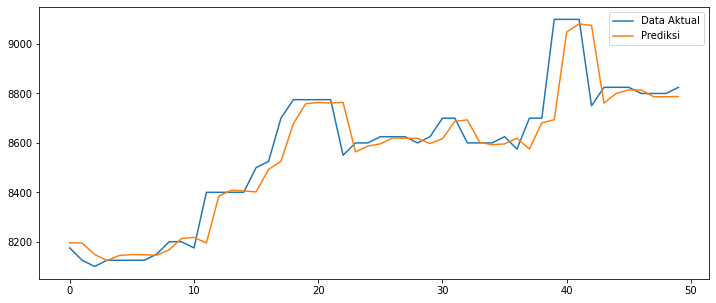

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0][:50])
plt.plot(train_predict2[:50])
plt.legend(['Data Aktual', 'Prediksi'])

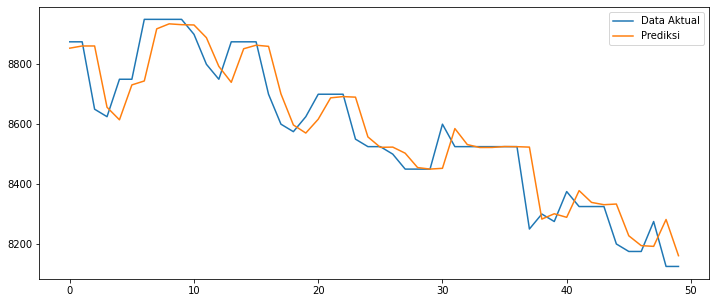

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][:50])
plt.plot(test_predict2[:50])
plt.legend(['Data Aktual', 'Prediksi'])

# Perbandingan

## Vanilla

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict)

,MSE,RMSE,MAE,MAPE
0,22317.417773,149.390153,100.44915,0.010407


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict)

,MSE,RMSE,MAE,MAPE
0,14976.625376,122.379023,87.167432,0.010493


## CNN-LSTM

In [ ]:
metrics_evaluation_regression(y_train2, lstmcnn.predict(X_train2))

,MSE,RMSE,MAE,MAPE
0,19680.56353,140.287432,84.143688,0.008833


In [ ]:
metrics_evaluation_regression(y_test2, lstmcnn.predict(X_test2))

,MSE,RMSE,MAE,MAPE
0,11903.910186,109.105042,71.649232,0.008518


## BiLSTM

In [ ]:
metrics_evaluation_regression(train_y[0], train_predict2)

,MSE,RMSE,MAE,MAPE
0,17973.617383,134.06572,78.633088,0.008204


In [ ]:
metrics_evaluation_regression(test_y[0], test_predict2)

,MSE,RMSE,MAE,MAPE
0,11413.950255,106.836091,67.162503,0.008017


## Chart 

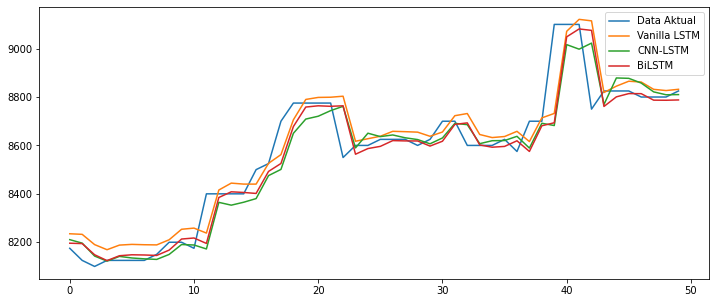

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_y[0][:50])
plt.plot(train_predict[:50])
plt.plot(cnn_train[:50])
plt.plot(train_predict2[:50])
plt.legend(['Data Aktual', 'Vanilla LSTM', 'CNN-LSTM', 'BiLSTM'])

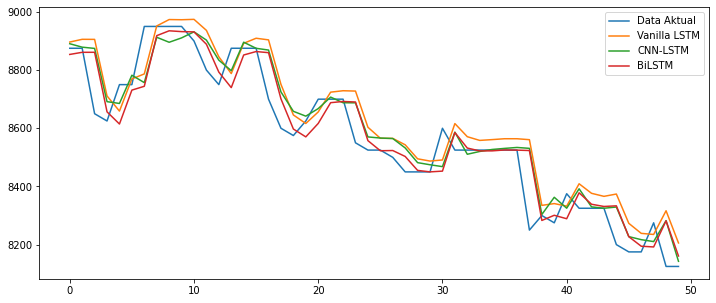

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y[0][:50])
plt.plot(test_predict[:50])
plt.plot(cnn_test[:50])
plt.plot(test_predict2[:50])
plt.legend(['Data Aktual', 'Vanilla LSTM', 'CNN-LSTM', 'BiLSTM'])

In [ ]:
trace1 = go.Scatter(
    x = weekly_rows['Date'],
    y = test_y[0].astype(float),
    mode = 'lines',
    name = 'Data Aktual'
)

trace2 = go.Scatter(
    x = weekly_rows['Date'],
    y = np.ravel(test_predict).astype(float),
    mode = 'lines',
    name = 'Vanilla LSTM'
)

trace3 = go.Scatter(
    x = weekly_rows['Date'],
    y = np.ravel(cnn_test).astype(float),
    mode = 'lines',
    name = 'CNN-LSTM'
)

trace4 = go.Scatter(
    x = weekly_rows['Date'],
    y = np.ravel(test_predict2).astype(float),
    mode = 'lines',
    name = 'Bi-LSTM'
)

layout = dict(
    title='ICBP Prices Test Prediction (2017-2022) with the Slider ',
    hovermode='x',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

# data = [trace1,trace2, trace3]
data = [trace1,trace2,trace3,trace4]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")
# fig.show()

# Feature Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, scoring="r2", random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = [f'lag-{7-i}' for i in range(7)])

Weight,Feature
0.0700 ± 0.0144,lag-2
0.0683 ± 0.0113,lag-5
0.0652 ± 0.0146,lag-4
0.0651 ± 0.0129,lag-6
0.0612 ± 0.0104,lag-3
0.0227 ± 0.0025,lag-1
0.0108 ± 0.0018,lag-7


In [ ]:
 [f'lag-{7-i}' for i in range(7)]

['lag-7', 'lag-6', 'lag-5', 'lag-4', 'lag-3', 'lag-2', 'lag-1']

# Hyperparameter Tuning

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  n_steps, n_features = 7, 1
  model = Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_filter = hp.Int('units_filter', min_value=8, max_value=512, step=32)
  hp_units_lstm = hp.Int('units_lstm', min_value=8, max_value=512, step=32)
  hp_units_dense = hp.Int('units_dense', min_value=8, max_value=512, step=32)
  model.add(Reshape((n_steps, n_features), input_dim=n_steps))
  model.add(Conv1D(filters=hp_filter, kernel_size=2, activation='relu'))
  model.add(LSTM(hp_units_lstm, activation='relu'))
  model.add(Dense(hp_units_dense, activation='relu'))
  model.add(Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')

  return model

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
n_steps, n_features = 7, 1
X, y = input_output_split_sequence(ts, n_steps)

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='cnn-lstm_model',
                     project_name='during_covid',
                    # # FOR TRAIN ONLY
                    #  overwrite=True
                    # # --------------
                     )

tuner.search(X, y, epochs=50, callbacks=[stop_early], validation_split=0.2,)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuning = ['units_filter', 'units_lstm', 'units_dense', 'learning_rate']
print('Best tune:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune:
units_filter: 72
units_lstm: 296
units_dense: 296
learning_rate: 0.01


## Skenario Penelitian

**Hyperparameter:** dari Hyperband atau RandomSearch untuk masing-masing arsitektur

**Epoch:** Jumlah epoch kelipatan 50 (3-5 jenis epoch)

**Time Steps:** 5 jenis(?) dengan epoch yg terbaik untuk masing2 arsitektur.